# seq2seq: Train

Quarks To Cosmos with AI Virtual Conference: July 12-16, 2021, Carnegie Mellon University

## Contributors

Abdulhakim Alnuqaydan, Ali Kadhim, Sergei Gleyzer, Harrison Prosper

## Hackathon Contributors

Andrew Roberts, Jessica Howard, Samuel Hori, Arvind Balasubramanian, Xiaosheng Zhao, Michael Andrews

July 2021

## Description

Use an encoder/decoder model built using LSTMs to map symbolic mathematical expressions $f(x)$ to their Taylor series expansions to ${\cal O}(x^5)$.

We've heavily borrowed from Charon Guo's excellent tutorial at:

https://charon.me/posts/pytorch/pytorch_seq2seq_1/

### Model Fitting

This notebook performs the following tasks:
  1. Read the sequence pairs from __data/seq2seq_data_10000.txt__.
  1. Convert the sequence pairs to pairs of integer-coded arrays.
  1. Create dataloaders for the train, validation, and test sets.
  1. Implement the sequence to sequence (seq2seq) model.
  1. Fit the model to the data, taking care to save the best model as determined by the validation score,  and compute the cross entropy on the full test set. 
  
Notes:
  1. We tokenize down to the level of characters, that is, each character is a token. However, it may be more sensible to keep words such as $\sin$, $\cos$, etc., as single tokens.
  1. We do not pad the sequences, consequently, the cross entropy calculation is quite noisy.

### Using Google Colaboratory
If you want to use Google colab then uncomment the instructions in the next cell. When that cell is executed, you'll be directed to a Google sign-in page. Once signed in, copy the validation code into the entry window on this page.

In [1]:
#from google.colab import drive 
#drive.mount('/content/gdrive')
#import sys
#sys.path.append('/content/gdrive/My Drive/AI')

In [2]:
# symbolic mathematics
import sympy as sp
from sympy import exp, \
    cos, sin, tan, \
    cosh, sinh, tanh, ln, log, E

x = sp.Symbol('x')

# array manipulation
import numpy as np
import random as rn
import math
import time
import matplotlib as mp
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
from torch import optim

# custom data prep and loader
from seq2sequtil import loadData, \
Seq2SeqDataPreparer, Seq2SeqDataLoader

# enable pretty printing of symbolic equations
from IPython.display import display
sp.init_printing(use_latex='mathjax')

# draw graphs inline
%matplotlib inline

In [3]:
#BASE = '/content/gdrive/My Drive/AI'
BASE = '.'

Duration of an epoch.

In [4]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Function to count the number of parameters in a model

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Load sequence data

In [6]:
inputs, targets = loadData('%s/data/seq2seq_data_10000.txt' % BASE)

Example source:
	(4*x**2-1)*cos(2*x+9)/cosh(7*x**3/7)/(8*x-8)*exp(-5*x**2+1)



                   2             
⎛   2    ⎞  1 - 5⋅x              
⎝4⋅x  - 1⎠⋅ℯ        ⋅cos(2⋅x + 9)
─────────────────────────────────
                      ⎛ 3⎞       
        (8⋅x - 8)⋅cosh⎝x ⎠       

Example target:
	E*cos(9)/8+x*(E*cos(9)/8-E*sin(9)/4)+x**2*(-E*sin(9)/4-5*E*cos(9)/4)+x**3*(13*E*sin(9)/6-5*E*cos(9)/4)+x**4*(247*E*cos(9)/48+13*E*sin(9)/6)



 4 ⎛247⋅ℯ⋅cos(9)   13⋅ℯ⋅sin(9)⎞    3 ⎛13⋅ℯ⋅sin(9)   5⋅ℯ⋅cos(9)⎞    2 ⎛  ℯ⋅sin(
x ⋅⎜──────────── + ───────────⎟ + x ⋅⎜─────────── - ──────────⎟ + x ⋅⎜- ──────
   ⎝     48             6     ⎠      ⎝     6            4     ⎠      ⎝     4  

9)   5⋅ℯ⋅cos(9)⎞     ⎛ℯ⋅cos(9)   ℯ⋅sin(9)⎞   ℯ⋅cos(9)
── - ──────────⎟ + x⋅⎜──────── - ────────⎟ + ────────
         4     ⎠     ⎝   8          4    ⎠      8    

### Convert sequence data
  1. Scan input and output sequences and construct maps of characters (tokens) to indices, one map for input sequences and another for target sequences.
  1. Pad sequences to the same length
  1. Split into train, validation, and test sets.

In [7]:
import seq2sequtil as sq
import importlib 
importlib.reload(sq)

fractions=[8/10, 9/10]

db = sq.Seq2SeqDataPreparer(inputs, targets, fractions)

print(db)

number of seq-pairs (train):     8000
number of seq-pairs (valid):     1000
number of seq-pairs (test):      1000

number of source tokens:           31
max source sequence length:        81

number of target tokens:           35
max target sequence length:       923


Note: The class __Seq2SeqDataLoader__ is a custom dataloader that returns batches of sequence pairs comprising sources and targets, X and Y, respectively. The quantities X and Y are 2D tensors, each with shape (max_seq_len, batch_size) that comprise sequences of indices arranged in columns. Each index corresponds to a token, i.e., a character. The column lengths, max_seq_len, differ between X and Y.


__NB:__ Remember to initialize the dataloader (really a data sampler) using its __init_(num_samples, sample)__ method (formally known as reset).

In [9]:
DEVICE  = torch.device("cuda" \
                           if torch.cuda.is_available() \
                           else "cpu")
print('DEVICE:', DEVICE)

train_dataloader = Seq2SeqDataLoader(db.train_data, device=DEVICE)
valid_dataloader = Seq2SeqDataLoader(db.valid_data, device=DEVICE)
test_dataloader  = Seq2SeqDataLoader(db.test_data,  device=DEVICE)

DEVICE: cpu


## Implement encoder

### LSTM 

An LSTM is a function that is typically conceptualized as a "device" containing various "gates" that filter input data in different ways. This creative conceptual reasoning has yielded functions with amazing capabilities. However, it is far from clear that this approach will be the way forward in the future. Why? Because we have compelling evidence that highly creative conceptual reasoning, while impressive, is not, actually, needed to arrive at functions with immense capability. The existence of human brains that have evolved through natural selection is an existence proof that immensely capable functions can be arrived at through trial and error.

No doubt, one day, someone will devise an effective evolutionary algorithm that will compress millions of years of evolution into a matter of weeks or even days in order to construct immensely capable functions that could far outstrip what could be done through reasoning. 

#### LSTM Function

At time step $t$, instances of the LSTM class in PyTorch compute the function

\begin{align*}
 g_t & = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}),\\
 i_t & = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}),\\
 f_t & = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}),\\ \\
 o_t & = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}),\\
 c_t & = f_t \odot c_{t-1} + g_t \odot i_t,\\
 h_t & = o_t \odot \tanh(c_t),
\end{align*}

where $\sigma$ is a sigmoid and $\odot$ is the Hadamard product. The functions $i_t$, and $f_t$ are called the *input* and *forget* gates, respectively, while $c_t$ and $h_t$ are called the *cell* and *hidden* states, respectively, of the LSTM. The cell and hidden states $c_{t-1}$ and $h_{t-1}$ are from the previous time step. The number of elements that comprise the cell and hidden states is specified by the *hidden_size* argument of the PyTorch LSTM. The $W$s and $b$s are the parameters of the LSTM function. The LSTM outputs $o_t, (h_t, c_t)$.

### PyTorch LSTM Parameters

* input_size – The number of expected features in the input x
* hidden_size – The number of features in the hidden state h
* num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
* bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True
* batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
* dropout – If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
* bidirectional – If True, becomes a bidirectional LSTM. Default: False
* proj_size – If > 0, will use LSTM with projections of corresponding size. Default: 0

### Encoder
  * num_features - Number of unique source tokens
  * embed_size - Dimension of embedding space for tokens
  * hidden_size - See above
  * number_layers - See above
  * dropout - See above
  * device - device on which to do calculations
  
### Decoder
  * num_features - Number of target tokens
  * embed_size - Dimension of embedding space for tokens
  * hidden_size - See above
  * number_layers - See above
  * dropout - See above
  * device - device on which to do calculations

In [23]:
HIDDEN_SIZE = 64        # size of vectors holding hidden and cell states
NUM_LAYERS  =  2        # number of LSTM layers

ENCODER_EMBED_SIZE = 10 # dimension of token embedding space for encoder
ENCODER_DROPOUT    = 0.5# probability to zero out a node

DECODER_EMBED_SIZE = 10 # dimension of token embedding space for decoder
DECODER_DROPOUT    = 0.5# probability to zero out a node

CLIP    =   1   # prevent gradients from exploding!
N_EPOCHS= 500   # default number of epochs

SOS     = db.y_token2index['\t'] # Start-Of-Sequence
EOS     = db.y_token2index['\n'] # End-Of-Sequence 
PADDING = db.y_token2index[' ']

In [11]:
class Encoder(nn.Module):
    def __init__(self, num_features, 
                 embed_size=ENCODER_EMBED_SIZE, 
                 hidden_size=HIDDEN_SIZE, 
                 num_layers=NUM_LAYERS, 
                 dropout=ENCODER_DROPOUT,
                 device=DEVICE):
        
        super(Encoder, self).__init__()
        
        self.num_features= num_features
        self.embed_size  = embed_size
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.dropout     = dropout
        
        # The embedding will map each index associated with a token 
        # into a vector of dimension embed_size, where in a typical
        # natural language translation task embed_size << num_features.
        # However, in this example that is not the case.
        #
        # The shape of the inputs to the embedding object is 
        #  (sequence_length, batch_size).
        #
        # The shape of the outputs is 
        #  (sequence_length, batch_size, embed_size)
        self.embedding = nn.Embedding(num_features, 
                                      embed_size).to(device)
        
        # By default, LSTM expects the input shape to be
        #  (seq_len, batch_size, embed_size) (seq_len: sequence_length)
        self.lstm = nn.LSTM(embed_size, 
                            hidden_size, 
                            num_layers,
                            dropout=dropout).to(device)


    def forward(self, x):
        # x.shape: (seq_len, batch_size)
       
        x = self.embedding(x)
        # x.shape: (seq_len, batch_size, embed_size)
        
        output, (hidden, cell) = self.lstm(x)
        # output.shape: (seq_len, batch_size, hidden_size)

        # we discard output of encoder
        return hidden, cell

## Implement Decoder

The decoder is similar to the encoder in that it has an embedding layer that maps the target features (the indices associated with the characters in the target sequences) to a vector in an embedding space. 

The key difference is that the output of the LSTM is passed to a *Linear* layer that outputs a vector equal in size to the number of features, i.e., unique tokens associated with the target sequences. 

Starting with the start of sequence (SOS) token (here a tab), the decoder outputs a vector of floats each corresponding to a target token. The ordinal value of the largest float is the decoder's prediction of the next token in the target sequence. The prediction forms the input token for the next call to the decoder. The decoder is called repeatedly until it predicts an end of sequence (EOS) token (here a newline) or the maximum target sequence length is reached.

In [12]:
class Decoder(nn.Module):
    '''
    num_features number of target features, i.e., tokens
    '''
    def __init__(self, num_features, 
                 embed_size=ENCODER_EMBED_SIZE, 
                 hidden_size=HIDDEN_SIZE, 
                 num_layers=NUM_LAYERS, 
                 dropout=ENCODER_DROPOUT,
                 device=DEVICE):
        super(Decoder, self).__init__()
        
        self.num_features= num_features  # number of target tokens
        self.embed_size  = embed_size
        self.hidden_size = hidden_size
        self.num_layers  = num_layers
        self.dropout     = dropout
        self.device      = device
 
        # The shape of inputs must be (seq_len, batch_size)
        # The shape of outputs is (seq_len, batch_size, embed_size)
        self.embedding   = nn.Embedding(num_features, 
                                        embed_size).to(device)

        # inputs.shape:  (seq_len, batch_size, embed_size)
        # outputs.shape: (seq_len, batch_size, hidden_size)
        self.lstm = nn.LSTM(input_size  = embed_size, 
                            hidden_size = hidden_size, 
                            num_layers  = num_layers,
                            dropout     = dropout).to(device)

        # inputs.shape:  (batch_size, hidden_size)
        # outputs.shape: (batch_size, num_features)
        self.linear = nn.Linear(hidden_size, num_features).to(device)

    def forward(self, source, hidden, cell):
        # For a given batch instance, the indices of tokens will be 
        # passed one by one to this function. Therefore, the source
        # is a 1D tensor of token indices of shape (batch_size).
        # But since the embedding object requires an input with shape 
        # (seq_len, batch_size) we need to use unsqueeze(0) to 
        # insert an extra dimension of size 1 at dim=0 so that the
        # shape is (1, batch_size).
        
        source = source.unsqueeze(0)
        # source.shape:   (1, batch_size)
        
        # Map each index in the batch of indices to its embedded 
        # representation.
        embedded = self.embedding(source)
        # embedded.shape: (1, batch_size, embed_size)
                
        # Input embedded representation of token and previous
        # hidden and cell states to lstm
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output.shape:   (1, batch_size, hidden_size)
        
        # Get rid of dim 0 of length "1" to match shape expected by
        # the linear layer
        output = output.squeeze(0) 
        # output.shape:   (batch_size, hidden_size)
        
        prediction = self.linear(output)
        # prediction.shape: (batch_size, num_features)
        
        # We don't need to apply a softmax to prediction because 
        # this is done by the PyTorch cross entropy class. 
        # However, we may want to do so at some point, if we write
        # our own custom average loss function.
        return prediction, hidden, cell

### Construct seq2seq model

In [13]:
class Model(nn.Module):
    '''
    model = Model(encoder, decoder, device)
    '''
    def __init__(self, encoder, decoder, device, teacher_prob=0.0):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device  = device
        self.teacher_prob = teacher_prob
        self.num_features = self.decoder.num_features
        
        assert encoder.hidden_size == decoder.hidden_size, \
            "hidden_size of encoder and decoder must be equal!"
        
        assert encoder.num_layers == decoder.num_layers, \
            "num_layers of encoder and decoder must be equal!"
        
    def forward(self, source, target):
        '''
    1.  If target is a tuple, then it is interpreted as:
        target = (target, teacher_prob)
            
    2.  If the target is not a tuple, it is assumed to be the target
        and the teacher_prob is set to 0.5
        '''

        if type(target) == type(()):
            target, teacher_prob = target
        else:
            teacher_prob = self.teacher_prob
            
        y_seq_len, batch_size  = target.shape
            
        # source.shape = (x_seq_len, batch_size)
        # target.shape = (y_seq_len, batch_size)
        #
        # teacher_prob is the probability, during training, to 
        # use the true target rather than the predicted target.
        # ideally that probability should be gradually reduced 
        # as the training progresses.
           
        # Tensor to store decoder outputs
        outputs = torch.zeros(y_seq_len, 
                              batch_size, 
                              self.num_features, 
                              device=self.device)
        
        # Use last hidden state of the encoder as the initial 
        # hidden state of the decoder. (Note: the encoder discards
        # the output of the LSTM.)
        hidden, cell = self.encoder(source)
        
        # Repeatedly call decoder and have it predict which target
        # token should come next.
        #
        # The first input to the decoder should be the index 
        # associated with the tab token of the target sequence
        index = target[0,:]
        
        for t in range(1, y_seq_len):
            
            output, hidden, cell = self.decoder(index, hidden, cell)
            
            # Cache predictions for each token
            # output.shape: (batch_size, num_features)
            # Note: following does a deepcopy of output to outputs[t]
            outputs[t] = output
                       
            # The prediction is the ordinal value of the feature with 
            # the largest value
            prediction = output.argmax(1) 
            
            # For the next index, decide whether to use the 
            # target or the prediction, that is, whether to ask the
            # teacher for help 
            if self.training:
                use_target = rn.random() < teacher_prob
                index = target[t] if use_target else prediction
            else:
                index = prediction   
                            
        # Note: For a given batch instance, the num_features outputs
        # do not sum to unity.
        return outputs
    
    def predict(self, source, y_max_seq_len=1000):
        # source.shape = (x_seq_len)
        
        sos = source[0]   # start of sequence code
        eos = source[-1]  # end of sequence code
        
        # Tensor to store decoder predictions
        predictions = torch.zeros(y_max_seq_len,
                                  dtype=torch.long,
                                  device=self.device)
        
        # Use last hidden state of the encoder as the initial 
        # hidden state of the decoder.
        
        # encoder expects input of shape (seq_len, batch_size), so
        # we need to unsqueeze, that is, expand into the batch
        # dimension
        source = source.unsqueeze(1)
        # source.shape = (x_seq_len, 1)
        
        hidden, cell = self.encoder(source)
        
        # Repeatedly call decoder to get predicted target sequence.
        # The first input to the decoder should be the index 
        # associated with the tab token. Here we assume that the
        # source and target tab and newline codes are the same!
        index = source[0, :]
        count = 0
        
        for t in range(1, y_max_seq_len):
            count += 1
            
            output, hidden, cell = self.decoder(index, hidden, cell)
            # output.shape: (1, num_features)
            
            # Predict next token by returning the ordinal value
            # of the output "feature" with the largest value
            index = output.argmax(1) 
            if index == eos:
                break
                
            # cache prediction
            predictions[t-1] = index
        
        # send results to CPU
        return predictions[:count].cpu()

### Train Model

  1. Create an encoder
  1. Create a decoder
  1. Create a encoder/decoder model
  1. Train model

In [14]:
num_source_features = db.num_tokens('source')

encoder = Encoder(num_source_features, 
                  ENCODER_EMBED_SIZE, 
                  HIDDEN_SIZE, 
                  NUM_LAYERS, 
                  ENCODER_DROPOUT).to(DEVICE)

num_target_features = db.num_tokens('target')

decoder = Decoder(num_target_features, 
                  DECODER_EMBED_SIZE, 
                  HIDDEN_SIZE, 
                  NUM_LAYERS, 
                  DECODER_DROPOUT).to(DEVICE)

model = Model(encoder, decoder, DEVICE).to(DEVICE)

print(model)
print('Computational device:      %s' % DEVICE)
print('Number of free parameters: %d' % count_parameters(model))

Model(
  (encoder): Encoder(
    (embedding): Embedding(31, 10)
    (lstm): LSTM(10, 64, num_layers=2, dropout=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(35, 10)
    (lstm): LSTM(10, 64, num_layers=2, dropout=0.5)
    (linear): Linear(in_features=64, out_features=35, bias=True)
  )
)
Computational device:      cpu
Number of free parameters: 108407


### Choose optimizer

In [15]:
optimizer = optim.Adam(model.parameters())

### Choose loss function
For each token with associated index k, compute the cross-entropy loss

\begin{align*}
    E_k & = -\log \left( \frac{\exp(\hat{y}_k)}{\sum_{\{j\}} \exp(\hat{y}_j) } \right) ,
\end{align*}

where $\hat{y}_j$ is the $j^\text{th}$ element of the model's output vector of length *num_features*. The losses $E_k$ are averaged over all tokens in a sequence and all batch instances. The set $\{ j \}$  excludes tokens that correspond to padding. 

In [16]:
criterion = nn.CrossEntropyLoss(ignore_index=PADDING).to(DEVICE)

### Define trainer

In [17]:
def train(model, dataloader, optimizer, criterion, device, 
          clip, num_samples=100):
    
    # set to train mode
    model.train()  
    
    epoch_loss = 0
    
    # X and Y are created directly on the device, 
    # which is most likely a GPU

    dataloader.init(num_samples)

    for i, (X, Y) in enumerate(dataloader):
        
        # zero gradients of all trainable parameters
        optimizer.zero_grad()
        
        # compute output of model
        output = model(X, Y)
        # output.shape: (y_seq_len, batch_size, num_features)
    
        # skip first token (a tab), then reshape to
        # ((y_seq_len-1)*batch_size, num_features)
        num_features = output.shape[-1]
        output = output[1:].view(-1, num_features)

        # skip first token (a tab), then reshape to
        # ((max_target_seq_len-1)*batch_size)
        Y = Y[1:].view(-1)
               
        # average loss over batches
        loss = criterion(output, Y)
        
        # compute gradients using automatic differentiation
        loss.backward()
        
        # clip gradients so they don't blow up
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # make one step in th model parameter space
        optimizer.step()
        
        epoch_loss += loss.item() # to CPU, if using a GPU

        #if i % 10 == 0:
        #    print(' %d' % i, end='')
            
    #print(' end', end='')
    return epoch_loss / (i+1)

### Evaluator

In evaluation mode, we turn off gradient calculation and we provide only the source sequences.

In [18]:
def evaluate(model, dataloader, criterion, device, 
             num_samples=100, sample=True):
    
    model.eval()
    
    epoch_loss = 0
   
    # no need to compute gradients
    with torch.no_grad():
    
        dataloader.init(num_samples, sample)
        
        for i, (X, Y) in enumerate(dataloader):
                        
            output = model(X, Y)
            # output.shape:
            # (y_seq_len, batch_size, num_features)

            # skip first token (a tab), then reshape to
            # ((y_seq_len-1)*batch_size, num_features)
            
            num_features = output.shape[-1]
            
            output = output[1:].view(-1, num_features)
                            
            # skip first token (a tab), then reshape targets to
            # ((y_seq_len-1)*batch_size)
            Y = Y[1:].view(-1)
               
            # average loss over mini-batches, excluding padding tokens
            loss = criterion(output, Y)
        
            epoch_loss += loss.item()
                
    return epoch_loss / (i + 1)

In [19]:
def train_me_record_loss(model_file, loss_file,
                         n_epochs=N_EPOCHS,  
                         device=DEVICE,
                         clip=CLIP):
  
    best_valid_loss = float('inf')
    
    for epoch in range(n_epochs):
    
        start_time = time.time()
    
        train_loss = train(model, train_dataloader, optimizer, 
                           criterion, device, clip)
        
        valid_loss = evaluate(model, valid_dataloader, 
                              criterion, device)

        end_time   = time.time()
        mins, secs = epoch_time(start_time, end_time)
    
        if valid_loss < best_valid_loss:
            # save best model so far
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_file)
    
        print('\repoch: %5d|%2.2d:%2.2d| train_loss: %7.4f |'\
              ' valid_loss: %7.4f' % \
              (epoch, mins, secs, train_loss, valid_loss), end='')
        
        # open file in append mode
        open(loss_file, 'a').write('%7.4f %7.4f\n' % (train_loss, 
                                                      valid_loss))
        
    print('\ndone!')

In [20]:
model_count = 0
model_file  = '%s/seq2seq_model_%2.2d.pth'  % (BASE, model_count)
loss_file   = '%s/seq2seq_losses_%2.2d.txt' % (BASE, model_count)

In [41]:
# training!
n_epochs = 2000 # number of times through training data

#model.load_state_dict(torch.load(model_file))

train_me_record_loss(model_file, loss_file, n_epochs)

epoch:  1999|00:13| train_loss:  2.3777 | valid_loss:  2.2395
done!


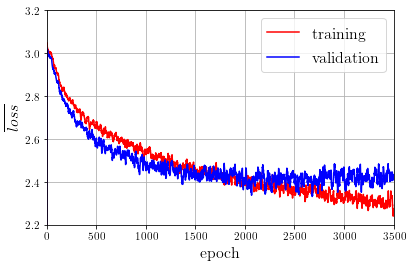

In [21]:
# update fonts
FONTSIZE = 16
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')
mp.rc('text', usetex=True)

def plot_losses(loss_file, plot_file='fig_losses.pdf', 
                xlimits=None, 
                ylimits=None):
    
    losses       = [a.split() for a in open(loss_file).readlines()]
    train_losses = [float(z)  for z, _ in losses]
    valid_losses = [float(z)  for _, z in losses]

    kernel_size  = 10
    kernel = np.ones(kernel_size) / kernel_size
    train_losses = np.convolve(train_losses, kernel, mode='same')
    valid_losses = np.convolve(valid_losses, kernel, mode='same')
    epochs       = np.arange(len(train_losses))
   
    # plot loss curves
    # set up an empty figure
    fig = plt.figure(figsize=(6, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows, ncols, index)
    
    ax.set_xlabel('epoch', fontsize=16)
    ax.set_ylabel('$\overline{loss}$', fontsize=16) 
    
    if xlimits: ax.set_xlim(xlimits)
    if ylimits: ax.set_ylim(ylimits)
    
    ax.plot(epochs, train_losses, c='red',  label='training')
    ax.plot(epochs, valid_losses, c='blue', label='validation')
    
    ax.grid(True, which="both", linestyle='-')
    ax.legend()

    fig.tight_layout()
    plt.savefig(plot_file)  
    plt.show()
    
plot_file   = '%s/seq2seq_losses_%2.2d_fig.pdf' % (BASE, model_count)
plot_losses(loss_file, plot_file=plot_file,
            xlimits=(0, 3500), ylimits=(2.2, 3.2))


### Compute average loss over full test set

In [22]:
model.load_state_dict(torch.load(model_file, 
                                 map_location=torch.device('cpu')))

test_loss = evaluate(model, test_dataloader, 
                     criterion, DEVICE,  
                     num_samples=-1, 
                     sample=False)
print('test loss: %7.4f' % test_loss)

test loss:  2.3740
